In [1]:
import cv2
import numpy as np
import pandas as pd
import time
import os
import glob
import shutil
import matplotlib.pyplot as plt
from horizon.flir_boson_settings import I, D, P

import tqdm
import quaternion
from scipy.spatial.transform import Rotation
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.spatial import Delaunay

from scipy.spatial import KDTree

import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.mask
import pyproj
from PIL import ImageColor
import shapely
from shapely import Polygon
import skimage 


plt.rcParams["figure.figsize"] = (15,20)


def thermal2rgb(img):
    if img is not None:
        # img = img - np.percentile(img, 1)
        # img = img / np.percentile(img, 99)
        # img = np.clip(img, 0, 1)
        img = skimage.exposure.equalize_adapthist(img, clip_limit=0.015)
        img = np.stack([img]*3, axis=2)
        return np.uint8(255*img) 
    return np.zeros((512, 640, 3), dtype=np.uint8)   

# def read_ortho_label(label):

In [2]:
# Project world -> camera -> image
# X: [x, y, z] (3, N)
def project_points(X, R_mat, P):
    r, c = X.shape
    # Transform points from world coordinates to camera coordinate frame 
    Xr = R_mat @ X

    # Switch ONR coordinate system to opencv coordinate frame
    Xc = Xr[[1, 2, 0], :]
    Xc = np.vstack([Xc, np.ones((1, c))])

    # Project to image coordinates with camera projection matrix
    coords = P @ Xc
    
    # Homogenize points
    coords_xy = coords[0:2, :] / coords[2, :]
    return coords_xy


def draw_overlay_and_pts(img, points, output_path, labels=None, color_map=None):
    orig_img = cv2.rotate(img, cv2.ROTATE_180)
    if labels is None:
        for i in range(points.shape[0]):
            xi, yi = points[i]
            cv2.circle(img, (xi, yi), radius=3, color=(0, 0, 255), thickness=-1)
    else:
        
        for i in range(points.shape[0]):
            xi, yi = points[i]
            cls = labels[i]
            if not np.isnan(cls):
                color = color_map[cls]
                cv2.circle(img, (xi, yi), radius=3, color=color, thickness=-1)    

    img = cv2.rotate(img, cv2.ROTATE_180)
    # cv2.imwrite(output_path, img)
    plt.imshow(np.hstack([orig_img, img]))
    plt.show()

    cv2.imwrite('castaic_lake50000_pts.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


# Overly complicated fix for the horizon line
def generate_binary_mask(img_shape, points, blur_size=5, blur_sigma=3, morph_kernel_size=5, iterations=1):
    binary_mask = np.zeros(img_shape, dtype=np.uint8)

    # Sort points by their x values
    sorted_points = sorted(points, key=lambda pt: pt[0])

    # Create a list of points for the polygon that covers the area above the given points
    polygon_points = [(0, 0)] + sorted_points + [(img_shape[1] - 1, 0)]

    # Convert the list of points to the format required by cv2.fillPoly
    polygon_points_array = np.array(polygon_points, dtype=np.int32).reshape(-1, 1, 2)

    # Fill the polygon
    cv2.fillPoly(binary_mask, [polygon_points_array], 1)

    # Apply Gaussian blur to the mask
    binary_mask = cv2.GaussianBlur(binary_mask.astype(np.float32), (blur_size, blur_size), blur_sigma)

    # Threshold the mask to create a smoother transition between the masked and unmasked regions
    _, binary_mask = cv2.threshold(binary_mask, 0.5, 1, cv2.THRESH_BINARY)

    # Apply morphological operations (dilation followed by erosion)
    kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
    binary_mask = cv2.dilate(binary_mask, kernel, iterations=iterations)
    binary_mask = cv2.erode(binary_mask, kernel, iterations=iterations)

    return binary_mask



def points_to_segmentation(img_shape, points, labels, color_map, mask=None):
    x, y = np.indices(img_shape)
    xy = np.column_stack((y.ravel(), x.ravel()))
    
    # Create KDTree from the points
    tree = KDTree(points)

    # Find nearest neighbors for each pixel in the image
    _, nearest_neighbors = tree.query(xy)

    # Create segmentation mask using the labels of the nearest neighbors
    segmentation_labels = labels[nearest_neighbors].reshape(img_shape)

    # Apply the binary mask if provided
    if mask is not None:
        segmentation_labels = np.where(mask, segmentation_labels, -1)

    # Create colorized segmentation mask
    colorized_mask = np.zeros((*img_shape, 3), dtype=np.uint8)
    for label, color in color_map.items():
        colorized_mask[segmentation_labels == label] = color
    
    return colorized_mask


def draw_overlay_and_labels(img, points, labels, output_path, color_map=None, alpha=0.5):
    orig_img = img
    img_shape = img.shape[:2]

    # Generate a binary mask from the original points
    binary_mask = generate_binary_mask(img_shape, points)

    colorized_mask = points_to_segmentation(img_shape, points, labels, color_map, mask=binary_mask)
    
    # Overlay the colorized segmentation mask on the image
    overlay = cv2.addWeighted(orig_img, 1 - alpha, colorized_mask, alpha, 0)

    orig_img = cv2.rotate(orig_img, cv2.ROTATE_180)
    overlay = cv2.rotate(overlay, cv2.ROTATE_180)

    cv2.imwrite('castaic_lake50000.png', orig_img)
    cv2.imwrite('castaic_lake50000_autoseg.png', cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

    # Display the original and overlay images side by side
    plt.imshow(np.hstack([orig_img, overlay]))
    plt.show()


In [3]:
def estimate_horizon_mask(q_wxyz, q_xyzw, Pn, z):
    N = 100
    y = 3200
    x = 5000

    # q = quaternion.as_quat_array(q_wxyz)
    # dummy_p = np.quaternion(0, 1, 0, 0)
    # res = np.sum(q*dummy_p)*q.conjugate()
    # theta_yaw = np.arctan2(res.y, res.x) # Yaw induced on dummy vector by quaternion
    # inv_R_yaw = quaternion.from_rotation_vector(np.array([0, 0, 1])*(-theta_yaw))
    # R_mat = quaternion.as_rotation_matrix(inv_R_yaw*q)
    # print(np.rad2deg(theta_yaw))

    r = Rotation.from_quat(q_xyzw)
    yaw, pitch, roll =  r.as_euler('ZYX', degrees=True)
    r = Rotation.from_euler('ZYX', [0, pitch, -roll], degrees=True)
    R_mat = r.as_matrix()

    # X = np.ones((3, N))
    # X[0, :] = x #np.linspace(-x, x, N)
    # X[1, :] = np.linspace(-y, y, N)
    # X[2, :] = z


    xx, yy = np.meshgrid(np.linspace(0, x, N), np.linspace(-y, y, N))
    zz = np.ones_like(xx)*(100)

    X = np.stack([xx, yy, zz], axis=2)
    X = X.reshape(-1, 3).T
    Xn = project_points(X, R_mat, Pn).T

    return Xn.astype(int)


Reading data
['>Time', 'image', 'camNED_qw', 'camNED_qx', 'camNED_qy', 'camNED_qz', 'camNED_vN', 'camNED_vE', 'camNED_vD', 'camNED_N', 'camNED_E', 'camNED_D', 'camLLA_lat', 'camLLA_lon', 'camLLA_alt', 'riverNED_Z', 'uavNED_qw', 'uavNED_qx', 'uavNED_qy', 'uavNED_qz', 'uavNED_N', 'uavNED_E', 'uavNED_D', 'uavLLA_lat', 'uavLLA_lon', 'uavLLA_alt']
Starting horizon estimation


  0%|          | 0/52995 [00:00<?, ?it/s]

/home/carson/data/thermal/2022-12-20_Castaic_Lake/flight4/images/thermal/thermal-50000.tiff


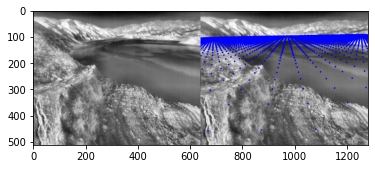

  0%|          | 0/52995 [00:00<?, ?it/s]


In [4]:
if os.path.exists('outputs') and os.path.isdir('outputs'):
    shutil.rmtree('outputs')
os.makedirs('outputs')

# DATA_PATH = '/media/hdd2/data/caltech_duck/ONR_2023-03-22-14-41-46'
DATA_PATH = '/home/carson/data/thermal/2022-12-20_Castaic_Lake/flight4'
# DATA_PATH = '../data'

print('Reading data')
alignment_data = pd.read_csv(os.path.join(DATA_PATH, "aligned.csv"), header=13)
alignment_data = alignment_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
alignment_data.columns = alignment_data.columns.str.replace(' ', '')
print(list(alignment_data))

H, W = (512, 640)
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(I, D, (W, H), 0, (W, H))
new_P = np.hstack([newcameramtx, np.zeros((3,1))])

print('Starting horizon estimation')
image_paths = sorted(glob.glob(os.path.join(DATA_PATH, 'images/thermal/*')))
for t, img_path in tqdm.tqdm(enumerate(image_paths), total=len(image_paths)):
    
    img_path = os.path.join(DATA_PATH, 'images/thermal/thermal-50000.tiff')
    # img_path = os.path.join(DATA_PATH, 'images/thermal/thermal-20000.tiff')
    # img_path = '/home/carson/data/thermal/2022-05-15_ColoradoRiver/flight3/images/thermal/thermal-02500.tiff'
    image_data = alignment_data[alignment_data['image'] == "images/thermal/{}".format(os.path.basename(img_path))]
    if len(image_data) == 0:
        continue
    print(img_path)

    cam_wxyz = image_data[['camNED_qw', 'camNED_qx', 'camNED_qy', 'camNED_qz']].values.astype(float)[0]
    cam_xyzw = image_data[['camNED_qx', 'camNED_qy', 'camNED_qz', 'camNED_qw']].values.astype(float)[0]
    height = image_data[['camNED_D']].values.astype(float)[0, 0]
    # z = height if not np.isnan(height) else -50  
    z = height - 38 #image_data[['riverNED_Z']].values.astype(float)[0, 0]
        
    output_path = 'outputs/{}'.format(os.path.basename(img_path).replace('tiff', 'png'))
    img = cv2.imread(img_path, -1)
    img = thermal2rgb(img)

    if np.isnan(cam_wxyz).any():
        undistorted_image = cv2.undistort(img, I, D, None, newcameramtx)
        img = cv2.rotate(undistorted_image, cv2.ROTATE_180)
        cv2.imwrite(output_path, img)
        continue

    undistorted_image = cv2.undistort(img, I, D, None, newcameramtx)
    Xn = estimate_horizon_mask(cam_wxyz, cam_xyzw, new_P, 300)
    draw_overlay_and_pts(undistorted_image, points=Xn, output_path=output_path)
    break

In [5]:
image_data[['camLLA_alt', 'riverNED_Z', 'camNED_D']]

,camLLA_alt,riverNED_Z,camNED_D
50000,446.522,-38.0,-19.470


In [6]:
alignment_data[['camLLA_alt', 'riverNED_Z', 'camNED_D']]

,camLLA_alt,riverNED_Z,camNED_D
0,NaN,-38.0,NaN
1,NaN,-38.0,NaN
2,NaN,-38.0,NaN
3,427.044,-38.0,0.000
4,427.044,-38.0,0.000
...,...,...,...
52990,428.904,-38.0,-1.860
52991,428.904,-38.0,-1.860
52992,428.904,-38.0,-1.860
52993,NaN,-38.0,NaN


In [7]:
def colorize_dynamic_world_label(label):
    hex_colors = [
        '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
        '#C4281B', '#FFA333', '#B39FE1'
    ]

    rgb_colors = [np.array(ImageColor.getcolor(c, "RGB")) for c in hex_colors]
    mapping = dict(zip(list(range(0, 9)), rgb_colors))

    h, w = label.shape
    color_label = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(0, 9):
        color_label[label == i, :] = mapping[i]
    
    return color_label


coords = image_data[['camLLA_lat', 'camLLA_lon']].values.astype(float)[0]
cam_xyzw = image_data[['camNED_qx', 'camNED_qy', 'camNED_qz', 'camNED_qw']].values.astype(float)[0]
r = Rotation.from_quat(cam_xyzw)
yaw, pitch, roll =  r.as_euler('ZYX', degrees=False)

mag = 3000
x_mag = 8000
y_mag = 3000
x_unit_vec = np.array([-np.cos(yaw + np.pi/2), np.sin(yaw + np.pi/2)])
heading_vec = x_unit_vec*mag 

# Faces right
y_unit_vec = np.array([-np.cos(yaw+np.pi), np.sin(yaw+np.pi)])
right_vec = y_unit_vec*y_mag

def power_spacing(num_points, start, end, exponent):
    linear_space = np.linspace(0, 1, num_points)
    power_space = np.power(linear_space, exponent)
    scaled_power_space = start + (end - start) * power_space
    return scaled_power_space

N = 200
exponent_x = 5
exponent_y = 5

x_space = power_spacing(N, 0, x_mag, exponent_x)
y_space_left = power_spacing(N // 2, 0.1, y_mag, exponent_y)
y_space_right = power_spacing(N // 2, 0.1, y_mag, exponent_y)[::-1]

x_magnitudes = x_space
y_magnitudes = np.concatenate((-y_space_right, y_space_left))

# N = 1000
# x_magnitudes = np.linspace(0, 7000, N)
# y_magnitudes = np.linspace(-5000, 5000, N)

# Create the grid of world points
xx, yy = np.meshgrid(x_magnitudes, y_magnitudes)
world_grid = np.stack([xx.transpose(1, 0), yy.transpose(1, 0)], axis=2)
world_pts = world_grid.reshape(-1, 2)


print(coords)
print(yaw, pitch, roll)

# with rasterio.open('horizon/duck-large.tif') as data:

with rasterio.open('label_mosaic_v2.tiff') as data:
    crs = data.crs
    tform = pyproj.Transformer.from_crs("epsg:4326", "epsg:{}".format(crs.to_epsg()))
    utm_e, utm_n = tform.transform(coords[0], coords[1])
    print(utm_e, utm_n)

    rows, cols = rasterio.transform.rowcol(data.transform, xs=utm_e, ys=utm_n)

    ptA_utm = np.array([utm_e, utm_n])
    ptA_rc = np.array([cols, rows])
    
    # # drone forward
    # ptB_utm = np.int64(ptA_utm + heading_vec)
    # rows, cols = rasterio.transform.rowcol(data.transform, xs=ptB_utm[0], ys=ptB_utm[1])
    # ptB_rc = np.array([cols, rows])

    # # drone left
    # ptA_left_utm = np.int64(ptA_utm - right_vec)
    # rows, cols = rasterio.transform.rowcol(data.transform, xs=ptA_left_utm[0], ys=ptA_left_utm[1])
    # ptA_left_rc = np.array([cols, rows])

    # # drone right
    # ptA_right_utm = np.int64(ptA_utm + right_vec)
    # rows, cols = rasterio.transform.rowcol(data.transform, xs=ptA_right_utm[0], ys=ptA_right_utm[1])
    # ptA_right_rc = np.array([cols, rows])

    # ptB_left_utm = np.int64(ptB_utm - right_vec)
    # ptB_right_utm = np.int64(ptB_utm + right_vec)

    # bbox = shapely.Polygon([ptA_left_utm, ptA_right_utm, ptB_right_utm, ptB_left_utm, ptA_left_utm])

    y_grid = y_unit_vec.reshape(2, 1) * y_magnitudes.reshape(1, N)
    x_grid = ptA_utm.reshape(2, 1) + x_unit_vec.reshape(2, 1) * x_magnitudes.reshape(1, N)

    utm_grid = x_grid.T.reshape(N, 1, 2) + y_grid.T.reshape(1, N, 2)

    # img_arr = data.read(10)
    # img_arr_rgb = colorize_dynamic_world_label(img_arr)
    
    # cv2.drawMarker(img_arr_rgb, ptA_rc, color=(0, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=100, thickness=3)
    # cv2.drawMarker(img_arr_rgb, ptB_rc, color=(0, 0, 0), markerType=cv2.MARKER_TILTED_CROSS, markerSize=100, thickness=8)
    # cv2.arrowedLine(img_arr_rgb, ptA_rc, ptB_rc, color=(0, 0, 0), thickness=15)

    # cv2.arrowedLine(img_arr_rgb, ptA_rc, ptA_left_rc, color=(0, 0, 255), thickness=15)
    # cv2.arrowedLine(img_arr_rgb, ptA_rc, ptA_right_rc, color=(0, 255, 0), thickness=15)

    # ax = plt.gca()
    # rasterio.plot.show(np.rollaxis(img_arr_rgb, 2), transform=data.transform, ax=ax)
    # xs,ys = bbox.exterior.xy
    # # ax.fill(xs, ys, alpha=1, fc='r', ec='#000000')
    # utm_grid_pts = utm_grid.reshape(-1, 2)
    # ax.scatter(utm_grid_pts[:, 0], utm_grid_pts[:,1], s=7, c='#000')
    # plt.show()

    sampled_labels = rasterio.sample.sample_gen(data, xy=utm_grid.reshape(-1, 2))
    
    # dsm = rasterio.open('microsoft_planetarycomputer_download/dsm/duck/mosaic/mosaic.tiff')
    # baseline_elevation = 2
    # dsm = rasterio.open('microsoft_planetarycomputer_download/dsm/castaiclake/mosaic/mosaic_epsg32611.tiff')
    dsm = rasterio.open('microsoft_planetarycomputer_download/dsm/castaiclake/mosaic/mosaic.tiff')
    baseline_elevation = 428.54 # Water elevation of Castaic Lake, Dec. 22, 2022
    sampled_z = rasterio.sample.sample_gen(dsm, xy=utm_grid.reshape(-1, 2))
    
    # world_coord_label_map = np.zeros((N*N, 4)) # x, y, z, label
    # for i, val in enumerate(sampled_labels):
    #     world_coord_label_map[i, 0:2] = world_pts[i]
    #     world_coord_label_map[i, 2] = 0
    #     world_coord_label_map[i, 3] = val 

    world_coord_label_map = np.zeros((N*N, 4)) # x, y, z, label
    for i, (val, h) in enumerate(zip(sampled_labels, sampled_z)):
        world_coord_label_map[i, 0:2] = world_pts[i]
        world_coord_label_map[i, 2] = np.clip(h - baseline_elevation, 0, None)
        world_coord_label_map[i, 3] = val[-1] 

    # Label points in back first
    ind = np.argsort(world_coord_label_map[:,0])[::-1]
    world_coord_label_map = world_coord_label_map[ind]
    surface_elevation = np.copy(world_coord_label_map[:, 2])
    world_coord_label_map[:, 2] = -world_coord_label_map[:, 2] - z

[  34.5325273 -118.6189996]
-0.39555311581623953 -0.3535440846037665 -3.1249122640612095
351421.2091206697 3822394.2773785326


In [8]:
# world_pts: (N*N, 4) - x, y, z, label
def world2cam(q_xyzw, Pn, z, world_pts):

    r = Rotation.from_quat(q_xyzw)
    yaw, pitch, roll =  r.as_euler('ZYX', degrees=True)
    r = Rotation.from_euler('ZYX', [0, pitch, -roll], degrees=True)
    R_mat = r.as_matrix()

    X = world_pts[:, 0:3].T
    Xn = project_points(X, R_mat, Pn).T
    return Xn.astype(int)

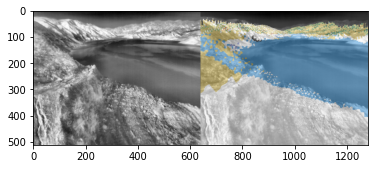

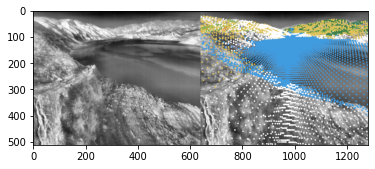

: 

In [17]:
hex_colors = [
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#ffffff', '#B39FE1'
]

rgb_colors = [ImageColor.getcolor(c, "RGB") for c in hex_colors]
color_map = dict(zip(list(range(0, 9)), rgb_colors))

undistorted_image = cv2.undistort(img, I, D, None, newcameramtx)
Xn = world2cam(cam_xyzw, new_P, z, world_coord_label_map)

draw_overlay_and_labels(undistorted_image, points=Xn, output_path=output_path, labels=world_coord_label_map[:,3], color_map=color_map)
draw_overlay_and_pts(undistorted_image, points=Xn, output_path=output_path, labels=world_coord_label_map[:,3], color_map=color_map)

In [10]:
fake_img = np.zeros((512, 640, 3), dtype=np.uint8)
maxval = np.percentile(surface_elevation, 50)
for i, (x, y) in enumerate(Xn):
    if 0 <= y < 512 and 0 <= x < 640:
        fake_img[y-2:y+2, x-2:x+2] = np.clip(surface_elevation[i] / float(maxval), 0, 1)*255
fake_img = cv2.rotate(fake_img, cv2.ROTATE_180)
fake_img2 = cv2.rotate(undistorted_image, cv2.ROTATE_180)

(-0.5, 1279.5, 511.5, -0.5)

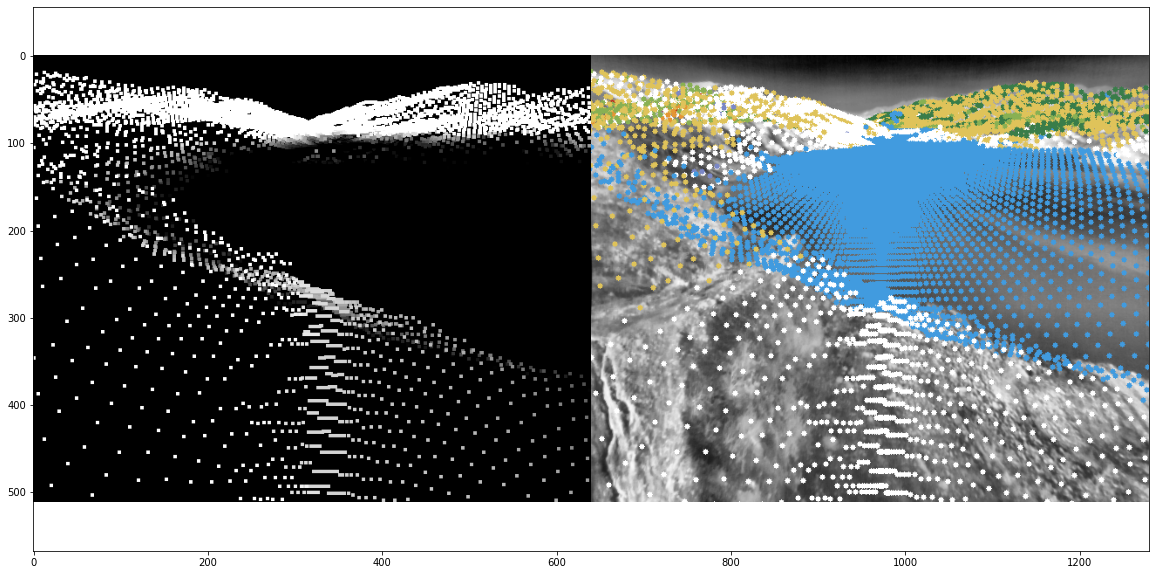

In [11]:
plt.figure(figsize=(20, 10))
plt.imshow(np.hstack((fake_img, fake_img2)))
plt.axis('equal')

[[304  98]]


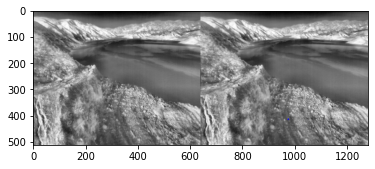

In [12]:
r = Rotation.from_quat(cam_xyzw)
yaw, pitch, roll =  r.as_euler('ZYX', degrees=True)
r = Rotation.from_euler('ZYX', [0, pitch, -roll], degrees=True)
R_mat = r.as_matrix()

pts = np.zeros((1, 3))
pts[0, 0] = 50
pts[0, 1] = 0
pts[0, 2] = -z -15

X = np.copy(pts.T)
Xp = project_points(X, R_mat, new_P).T.astype(int)
print(Xp)
img1 = cv2.undistort(img, I, D, None, newcameramtx)
draw_overlay_and_pts(img1, points=Xp, output_path=output_path, color_map=color_map)

In [13]:
# from rasterio.merge import merge

# files = glob.glob('horizon/dynamicworld-prob/castaic_lake_v2/*.tif')
# dss = [rasterio.open(f) for f in sorted(files)][::-1]
# ds, tform = merge(dss, nodata=0)

# out_meta = dss[0].meta.copy()
# out_meta.update({
#     "driver": "GTiff",
#     "height": ds.shape[1],
#     "width": ds.shape[2],
#     "transform": tform,
#     "crs": dss[0].crs
# })

# save_dir = '.'
# os.makedirs(save_dir, exist_ok=True)
# mosaic_save_path = os.path.join(save_dir, 'label_mosaic_v2.tiff')
# with rasterio.open(mosaic_save_path, 'w', **out_meta) as dest:
#     dest.write(ds)



In [14]:
d = rasterio.open('label_mosaic_v2.tiff')

<AxesSubplot:>

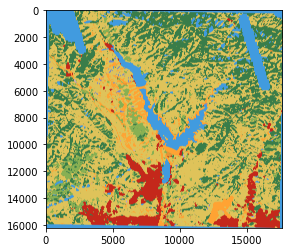

In [15]:
ds = d.read()
dsa = np.argmax(ds[:-1], axis=0)
# ds = np.argmax(ds, axis=0)
# ds.shape
img_arr_rgb = colorize_dynamic_world_label(dsa)
ax = plt.gca()
rasterio.plot.show(np.rollaxis(img_arr_rgb, 2), ax=ax)

In [16]:
cv2.imwrite('castaic_lake_rgb_label.png', cv2.resize(cv2.cvtColor(img_arr_rgb, cv2.COLOR_RGB2BGR), (0, 0), fx=0.15, fy=0.15))

True